# Test Notebook For SHAP

In [13]:
import numpy as np
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as plt
import xgboost
import shap
import pandas as pd

shap.initjs()

In [59]:
X,y = shap.datasets.boston()
model = xgboost.XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

In [72]:
# How to Choosing a right reference data..?

metric = 'correlation'
refs = shap.sample(X.values, nsamples=100)
masker = shap.maskers.Partition(data=refs, clustering=metric)
# masks out tabular features by integrating over the given background dataset.

# equals to:
bg_no_nan = refs.copy()
for i in range(bg_no_nan.shape[1]):
    np.nan_to_num(bg_no_nan[:,i], nan=np.nanmean(bg_no_nan[:,i]), copy=False)
dist = sp.spatial.distance.pdist(bg_no_nan.T + np.random.randn(*bg_no_nan.T.shape)*1e-8, metric=metric)
cluster_matrix = sp.cluster.hierarchy.single(dist)

print((cluster_matrix.round(2) == masker.clustering.round(2)).all())

True


In [105]:
def plot_dendrogram(X, idx):
    plt.figure(figsize=(15, 6))
    plt.title(f'Hierarchical Clustering Dendrogram for sample {idx}')
    plt.xlabel('Columns')
    plt.ylabel('Distance')
    sp.cluster.hierarchy.dendrogram(
        shap_values.clustering[idx],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=10.,  # font size for the x axis labels
        labels=X.columns
    )
    plt.show()

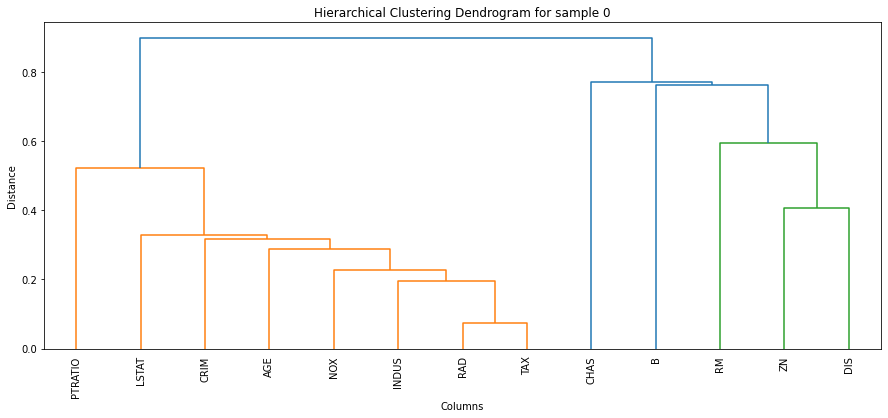

In [106]:
plot_dendrogram(X, idx=0)

In [121]:
f = lambda x: model.predict(x, output_margin=True, validate_features=False)
explainer = shap.TreeExplainer(model, data=refs, feature_names=X.columns)
pexplainer = shap.PartitionExplainer(f, masker=masker, feature_names=X.columns)

shap_values = explainer(refs)
pshap_values = pexplainer(refs)


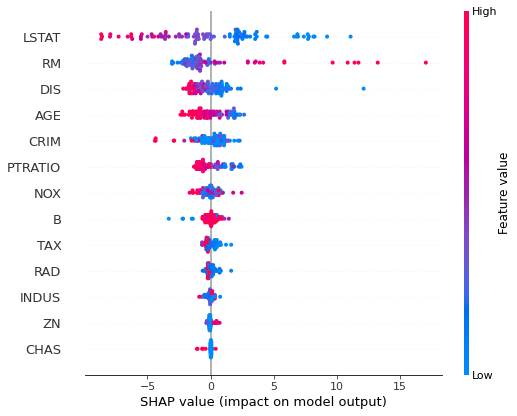

In [126]:
shap.summary_plot(pshap_values)

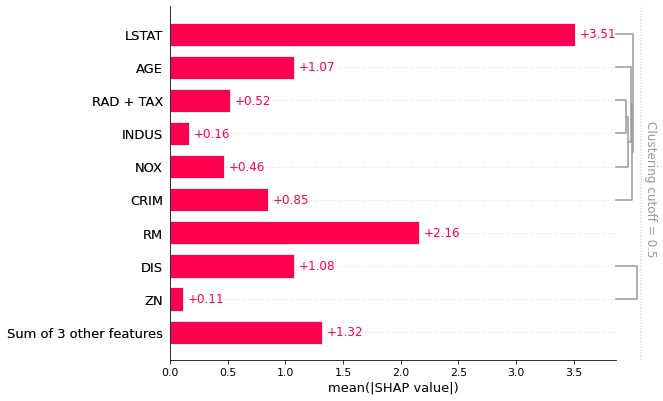

In [128]:
shap.plots.bar(pshap_values)

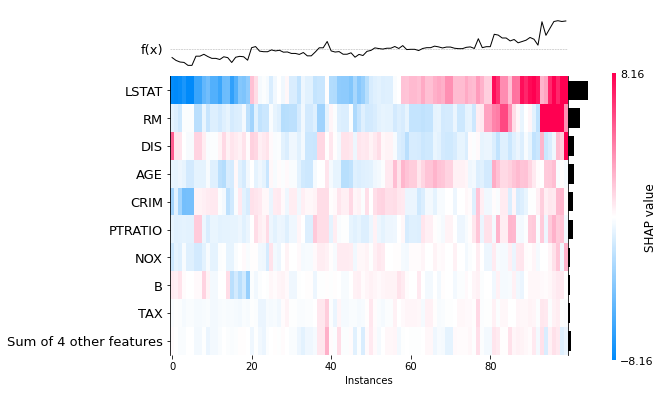

In [129]:
shap.plots.heatmap(pshap_values)

In [132]:
shap.plots.force(shap_values)

In [133]:
shap.plots.force(pshap_values)